In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect

In [40]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [198]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [199]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [200]:
# Use inspector to print table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [201]:
# Use inspector to get list of columns in the measurement table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [202]:
# Use inspector to get list of columns in the station table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [203]:
# Find the most recent date in the data set
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
recent_date


('2017-08-23',)

Text(0, 0.5, 'Precipitation in Inches')

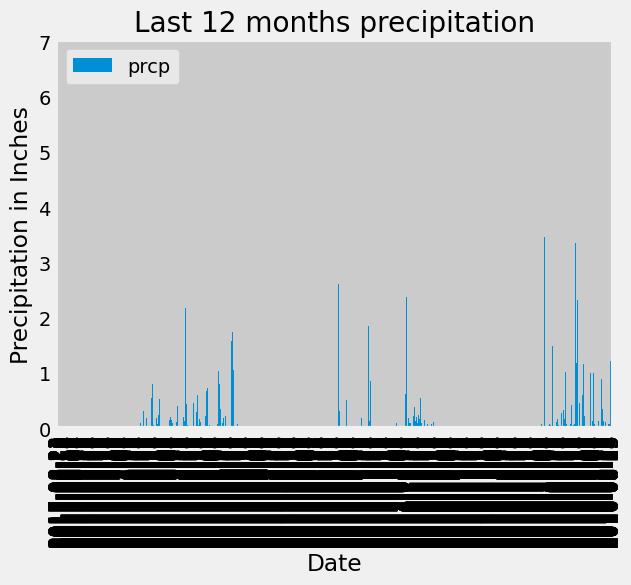

In [204]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date_recent = dt.datetime.strptime(recent_date[0], '%Y-%m-%d').date()
date_recent
# Calculate the date one year from the last date in data set.
year_ago = date_recent - dt.timedelta(days=365)
year_ago

# Perform a query to retrieve the data and precipitation scores
# Note: code below assumes prcp = precipitations scores & that we only want data for the last 12 months 
precipitation_data = session.query(measurement.date, measurement.prcp).filter(measurement.date>=year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data)
precipitation_df = precipitation_df.set_index("date")

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by="date",ascending=False)
precipitation_df


# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot.bar()
plt.title('Last 12 months precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation in Inches')





In [205]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [206]:
# Design a query to calculate the total number stations in the dataset
number_stations = session.query(station.station).distinct().count()
number_stations


9

In [207]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
# Note - this query assumes we're using the measurement to define the most active station
most_active = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
top_active = most_active[0][0]
top_active




'USC00519281'

In [208]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temperature = session.query(func.min(measurement.tobs)).filter(measurement.station == top_active).all()
lowest_temperature = lowest_temperature[0][0]

highest_temperature = session.query(func.max(measurement.tobs)).filter(measurement.station == top_active).all()
highest_temperature = highest_temperature[0][0]

average_temperature = session.query(func.avg(measurement.tobs)).filter(measurement.station == top_active).all()
average_temperature = average_temperature[0][0]

print(f'The lowest temperature for station {top_active} is {lowest_temperature}')
print(f'The highest temperature for statation {top_active} is {highest_temperature}')
print(f'The average temperature for station {top_active} is {round(average_temperature,0)}')

The lowest temperature for station USC00519281 is 54.0
The highest temperature for statation USC00519281 is 85.0
The average temperature for station USC00519281 is 72.0


Text(0, 0.5, 'Frequency')

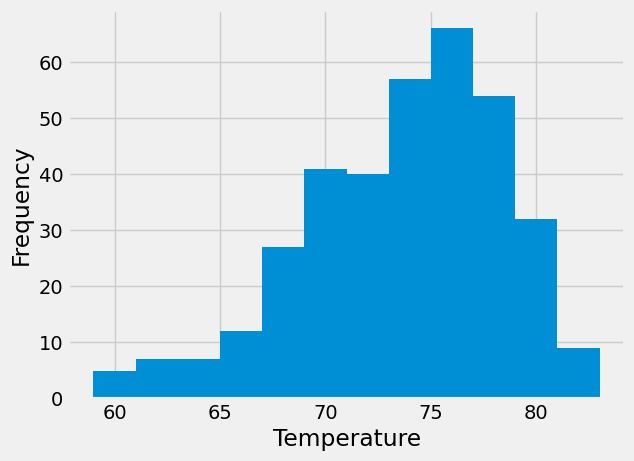

In [209]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#Gets most recent date for top station
recent_date_top_station = session.query(measurement.date).filter(measurement.station == top_active).order_by(measurement.date.desc()).first()
date_recent = dt.datetime.strptime(recent_date_top_station[0], '%Y-%m-%d').date()

#Calculates recent date - 365 days
year_ago = date_recent - dt.timedelta(days=365)

#Queries data
top_station = session.query(measurement.date,measurement.tobs).filter(measurement.station == top_active).filter(measurement.date >= year_ago).all()
top_station

# Save the query results as a Pandas DataFrame and set the index to the date column
top_station_df = pd.DataFrame(top_station)
top_station_df.set_index('date',inplace=True)


#Plots histogram 
plt.hist(top_station_df['tobs'],bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')


# Close session

In [191]:
# Close Session
session.close()